In [2]:
%load_ext autoreload
%autoreload 2

from src.rxn_ctr_mcs import *
from src.utils import load_json, rxn_entry_to_smarts
from src.pathway_utils import get_stoich_pk, get_reverse_paths_to_starting, create_graph_from_pickaxe

from minedatabase.pickaxe import Pickaxe
from minedatabase.utils import get_compound_hash

from rdkit.Chem import CanonSmiles, Draw
from rdkit import Chem
from rdkit.Chem import AllChem

import matplotlib.pyplot as plt
import numpy as np
import PIL
from collections import defaultdict
import pandas as pd
import csv

/home/stef/miniconda3/envs/mine/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at /home/stef/miniconda3/envs/mine/lib/python3.7/site-packages/rxnmapper/models/transformers/albert_heads_8_uspto_all_1310k were not used when initializing AlbertModel: ['predictions.LayerNorm.weight', 'predictions.decoder.weight', 'predictions.decoder.bias', 'predictions.bias', 'predictions.dense.weight', 'predictions.LayerNorm.bias', 'predictions.dense.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expec

In [3]:
# Define classes for pathway and reaction entries

class pathway:
    def __init__(self, rhashes, starter_hash=None, target_hash=None, prc_mcs=None, dG=None):
        self.starter = starter_hash
        self.target = target_hash
        self.rhashes = rhashes # Tuple of reaction hash ids
        self.prc_mcs = prc_mcs # Peri-rxn-ctr MCS score ave over reactions
        self.dG = dG # Placeholder for thermo

class reaction:
    def __init__(self, rid, smarts, rules=[], known_rxns=[]):
        self.rid = rid
        self.smarts = smarts
        self.rules = rules
        self.known_rxns = known_rxns

def rxn_hash_2_rxn_sma(rhash, pk):
    '''
    Make reaction smarts string for
    reaction indexed by rhash in a pk
    object
    '''
    rxn_stoich = get_stoich_pk(rhash, pk)
    products = ".".join([".".join([smi]*stoich) for smi, stoich in rxn_stoich.items() if stoich >= 0])
    reactants = ".".join([".".join([smi]*abs(stoich)) for smi, stoich in rxn_stoich.items() if stoich <= 0])
    rxn_sma = ">>".join([reactants, products])
    return rxn_sma

# Pathway drawing functions
def draw_rxn(rxn_sma):
    return Draw.ReactionToImage(
        AllChem.ReactionFromSmarts(rxn_sma, useSmiles=True),
        subImgSize=(200, 200), useSVG=False, drawOptions=None, returnPNG=False
    )

def get_concat_h(im1, im2):
    dst = PIL.Image.new('RGB', (im1.width + im2.width, max(im1.height, im2.height)))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

def get_concat_v(im1, im2):
    dst = PIL.Image.new('RGB', (max(im1.width, im2.width), im1.height + im2.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (0, im1.height))
    return dst

def draw_pathway(pred_known_pairs):
    for i, elt in enumerate(pred_known_pairs):
        if i == 0:
            img = get_concat_h(*elt)
        else:
            img = get_concat_v(img, get_concat_h(*elt))

    return img

## Main

In [4]:
# Set params

expansion_dir = '../../data_from_quest/bottle/'
fn = "succinate_to_mvacid_gen_4_tan_sample_n_samples_1000.pk" # Expansion file name
generations = 4

# Load results
pk = Pickaxe()
path = expansion_dir + fn
pk.load_pickled_pickaxe(path)

----------------------------------------
Intializing pickaxe object

Done intializing pickaxe object
----------------------------------------

Loading ../../data_from_quest/bottle/succinate_to_mvacid_gen_4_tan_sample_n_samples_1000.pk pickled data.
Loaded 89758 compounds
Loaded 106853 reactions
Loaded 3604 operators
Loaded 1 targets
Took 5.811366319656372


In [5]:
# Create the initial graph

DG, rxn, edge = create_graph_from_pickaxe(pk, "Biology")
starting_nodes = []
bad_nodes = []
for n in DG.nodes():
    try:
        if DG.nodes()[n]["Type"] == "Starting Compound":
            starting_nodes.append(n)
    except:
        bad_nodes.append(n)

RDKit ERROR: [17:14:11] Can't kekulize mol.  Unkekulized atoms: 19 23 26 27 28 29 30 31 33 34
[17:14:11] Can't kekulize mol.  Unkekulized atoms: 19 23 26 27 28 29 30 31 33 34

RDKit ERROR: 
RDKit ERROR: [17:14:11] Can't kekulize mol.  Unkekulized atoms: 19 23 26 27 28 29 30 31 33 34
RDKit ERROR: 
[17:14:11] Can't kekulize mol.  Unkekulized atoms: 19 23 26 27 28 29 30 31 33 34

RDKit ERROR: [17:14:19] Can't kekulize mol.  Unkekulized atoms: 19 23 26 27 28 29 30 31 33 34
[17:14:19] Can't kekulize mol.  Unkekulized atoms: 19 23 26 27 28 29 30 31 33 34

RDKit ERROR: 
RDKit ERROR: [17:14:19] Can't kekulize mol.  Unkekulized atoms: 19 23 26 27 28 29 30 31 33 34
RDKit ERROR: 
[17:14:19] Can't kekulize mol.  Unkekulized atoms: 19 23 26 27 28 29 30 31 33 34

RDKit ERROR: [17:14:19] Can't kekulize mol.  Unkekulized atoms: 19 23 26 27 28 29 30 31 33 34
RDKit ERROR: 
[17:14:19] Can't kekulize mol.  Unkekulized atoms: 19 23 26 27 28 29 30 31 33 34

RDKit ERROR: [17:14:19] Can't kekulize mol.  Unkek

In [6]:
# Get pathways
max_depth = generations * 2
paths = []

# Specify Targets / Starting Cpds
target_smi = pk.target_smiles[0]
target_cids = [get_compound_hash(smi)[0] for smi in pk.target_smiles]
starting_cpds = [get_compound_hash(val["SMILES"])[0] for val in pk.compounds.values() if val["Type"].startswith("Start")]

# Loop through targets and get pathways from targets to starting compounds
for this_target in target_cids:
    this_paths = get_reverse_paths_to_starting(DG, begin_node=this_target, end_nodes=starting_cpds, max_depth=max_depth)
    # If we find paths then reverse those paths and assign to a dictionary
    if this_paths:
        this_paths = list(set([tuple(path[1::2]) for path in [[*reversed(ind_path)] for ind_path in this_paths]]))
        for elt in this_paths:
            for r in pk.reactions[elt[0]]["Reactants"]:
                if r[-1] in starting_cpds:
                    paths.append(pathway(rhashes=elt, starter_hash=r[-1], target_hash=this_target)) 

In [7]:
# Make predicted reaction dict

pred_rxns = {}
degen_rhashes = defaultdict(lambda : 1)
for elt in paths:
    for this_rhash in elt.rhashes:
        if this_rhash not in pred_rxns:
            rxn_sma = rxn_hash_2_rxn_sma(this_rhash, pk)
            pred_rxns[this_rhash] = reaction(this_rhash, rxn_sma)
        else:
            degen_rhashes[this_rhash] += 1


In [8]:
# Put paths in dict indexed by starter-target pairs
# target_id_2_name = {'Cec77ea281f69ca989bbef0a4c7794128a196c716': '2-methyleneglutarate',
#                     'C3a5b833f1a5abe2063ff8b22706fabb74097bead': '4-methyleneglutamate'}
target_id_2_name = {'C6ec1611229ff4fc7a19244967c7716266fc021a1': 'mvacid'}

st_paths = defaultdict(list)
for elt in paths:
    t_name = target_id_2_name[elt.target]
    s_name = pk.compounds[elt.starter]["ID"]
    st_paths[(s_name, t_name)].append(elt)

for k,v in st_paths.items():
    print(k, len(v))

('succinate', 'mvacid') 41


In [9]:
# Load in IMT rule mapping

# Load rules
rules_path = '../src/rules/JN3604IMT_rules.tsv'
rule_df = pd.read_csv(rules_path, delimiter='\t')
rule_df.set_index('Name', inplace=True)

# Load mapping
rxn2rule = {}
db_names = ['_mc_v21', '_brenda', '_kegg']
suffix = '_imt_rules_enforce_cof.csv'
for name in db_names:
    mapping_path = '../data/mapping/mapping' + name + suffix
    with open(mapping_path, 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            if len(row) == 1:
                rxn2rule[row[0]] = []
            else:
                rxn2rule[row[0]] = row[1:]

# Make rule2rxn
rule2rxn = {}
for k,v in rxn2rule.items():
    for elt in v:
        if elt not in rule2rxn:
            rule2rxn[elt] = [k]
        else:
            rule2rxn[elt].append(k)

# Load all known reaction json entries into dict
known_rxns = {}
pref = '../data/mapping/'
suffs = ['mc_v21_as_is.json', 'brenda_as_is.json', 'kegg_as_is.json']
for elt in suffs:
    known_rxns.update(load_json(pref + elt))

In [11]:
# Populate reaction objects in rxn dict w/ known reactions

for k, v in pred_rxns.items():
    this_rules = list(pk.reactions[k]["Operators"])
    this_known_rxns = []
    for elt in this_rules:
        if elt in rule2rxn:
            this_rxn_ids = rule2rxn[elt]
            for this_id in this_rxn_ids:
                this_sma = rxn_entry_to_smarts(known_rxns[this_id])
                this_known_rxns.append((None, this_sma, this_id))
    
    v.known_rxns = [list(elt) for elt in set(this_known_rxns)]


In [13]:
# Populate pred_rxns, known rxn prc-mcs slot

for x in range(len(pred_rxns.keys())):
    h = list(pred_rxns.keys())[x]
    test_rxn = pred_rxns[h]
    a = 0 # Number known rxns analyszed
    for z, kr in enumerate(test_rxn.known_rxns):

        rxn_sma1 = test_rxn.smarts
        rxn_sma2 = kr[1]

        if tuple([len(elt.split('.')) for elt in rxn_sma2.split('>>')]) != tuple([len(elt.split('.')) for elt in rxn_sma1.split('>>')]):
            print(x, z, 'stoich_error')

        try:
            am_rxn_smarts = [atom_map(rxn_sma1), atom_map(rxn_sma2)] # Atom map
        except:
            continue

        # Construct reaction objects
        rxns = []
        for elt in am_rxn_smarts:
            temp = AllChem.ReactionFromSmarts(elt, useSmiles=True)
            temp.Initialize()
            rxns.append(temp)

        rc_atoms = [elt.GetReactingAtoms() for elt in rxns] # Get reaction center atom idxs

        # Construct rxn ctr mol objs
        rcs = []
        for i, t_rxn in enumerate(rxns):
            temp = []
            for j, t_mol in enumerate(t_rxn.GetReactants()):
                temp.append(get_sub_mol(t_mol, rc_atoms[i][j]))
            rcs.append(temp)

        # Align substrates of the 2 reactions
        rc_idxs = [] # Each element: (idx for rxn 1, idx for rxn 2)
        remaining = [[i for i in range(len(elt))] for elt in rcs]
        while (len(remaining[0]) > 0) & (len(remaining[1]) > 0):
            idx_pair = align_substrates(rcs, remaining)

            if idx_pair is None:
                break
            else:
                rc_idxs.append(idx_pair)
                remaining[0].remove(idx_pair[0])
                remaining[1].remove(idx_pair[1])

        if len(rc_idxs) < len(rxn_sma1.split('>>')[0].split('.')):
            continue

        rxns = align_atom_map_nums(rxns, rcs, rc_idxs, rc_atoms)

        prc_mcs = get_prc_mcs(rxns, rcs, rc_idxs, rc_atoms) # Compute MCS seeded by reaction center
        pred_rxns[h].known_rxns[z][0] = prc_mcs
        a += 1

    print(x, ':', a / (z+1), 'out of', z+1)

0 : 0.15 out of 40
1 : 0.15 out of 40
2 : 1.0 out of 20
3 : 0.6086956521739131 out of 23
4 : 0.6086956521739131 out of 23
5 : 0.0 out of 9
6 : 0.15 out of 40
7 : 0.0 out of 9
8 : 0.13636363636363635 out of 88
9 : 0.6086956521739131 out of 23
10 : 0.13636363636363635 out of 88
11 : 0.0 out of 88
12 : 1.0 out of 24
13 : 1.0 out of 18
14 : 0.15 out of 40
15 : 1.0 out of 20
16 : 1.0 out of 9
17 : 0.13636363636363635 out of 88
18 : 1.0 out of 24
19 : 0.15 out of 40
20 : 0.0 out of 9
21 : 1.0 out of 18
22 : 1.0 out of 9
23 : 0.13636363636363635 out of 88
24 : 1.0 out of 18
25 : 0.9310344827586207 out of 29
26 : 0.13636363636363635 out of 88
27 : 0.13636363636363635 out of 88
28 : 0.723404255319149 out of 47
29 : 0.9310344827586207 out of 29
30 : 0.723404255319149 out of 47
31 : 0.15 out of 40
32 : 0.0 out of 40


In [14]:
i = 0
for i, elt in enumerate(pred_rxns.values()):
    print(elt.known_rxns)
    if i > 10:
        break

[[None, 'CCC(=O)O.CC(C)(COP(=O)(O)OP(=O)(O)OCC1OC(n2cnc3c(N)ncnc32)C(O)C1OP(=O)(O)O)C(O)C(=O)NCCC(=O)NCCSC(=O)CCC(=O)O>>CCC(=O)SCCNC(=O)CCNC(=O)C(O)C(C)(C)COP(=O)(O)OP(=O)(O)OCC1OC(n2cnc3c(N)ncnc32)C(O)C1OP(=O)(O)O.O=C(O)CCC(=O)O', '2.8.3.18_22'], [[0.625, 0.16666666666666666], 'CC(=O)C(=O)O.CC(C(=O)O)C(=O)SCCNC(=O)CCNC(=O)C(O)C(C)(C)COP(=O)(O)OP(=O)(O)OCC1OC(n2cnc3c(N)ncnc32)C(O)C1OP(=O)(O)O>>O=C(O)CC(=O)C(=O)O.CCC(=O)SCCNC(=O)CCNC(=O)C(O)C(C)(C)COP(=O)(O)OP(=O)(O)OCC1OC(n2cnc3c(N)ncnc32)C(O)C1OP(=O)(O)O', 'R00930'], [None, 'CCC(=O)O.CC(C)(COP(=O)(O)OP(=O)(O)OCC1OC(n2cnc3c(N)ncnc32)C(O)C1OP(=O)(O)O)C(O)C(=O)NCCC(=O)NCCSC(=O)CCC(=O)O>>CCC(=O)SCCNC(=O)CCNC(=O)C(O)C(C)(C)COP(=O)(O)OP(=O)(O)OCC1OC(n2cnc3c(N)ncnc32)C(O)C1OP(=O)(O)O.O=C(O)CCC(=O)O', '2.8.3.1_30'], [None, 'CC(O)C(=O)O.O=C(O)CC(=O)C(=O)O>>O=C(O)CC(O)C(=O)O.CC(=O)C(=O)O', 'LACTATE-MALATE-TRANSHYDROGENASE-RXN_reverse'], [None, 'CC(C)(COP(=O)(O)OP(=O)(O)OCC1OC(n2cnc3c(N)ncnc32)C(O)C1OP(=O)(O)O)C(O)C(=O)NCCC(=O)NCCSC(=O)CCC(=O)O.

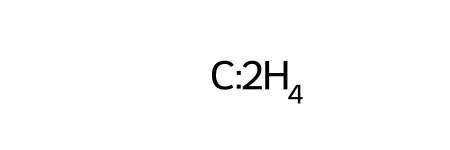

In [ ]:
rcs[0][1]

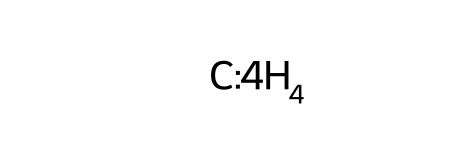

In [ ]:
rcs[1][1]

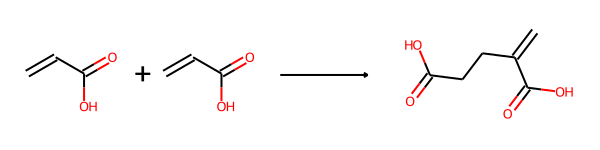

In [ ]:
AllChem.ReactionFromSmarts(rxn_sma1, useSmiles=True)

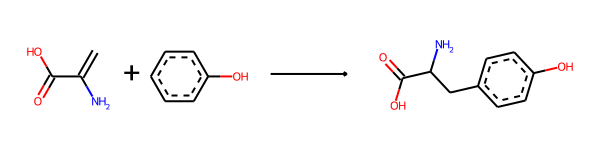

In [ ]:
AllChem.ReactionFromSmarts(rxn_sma2, useSmiles=True)

In [ ]:
[len(elt.split('.')) for elt in rxn_sma2.split('>>')], [len(elt.split('.')) for elt in rxn_sma1.split('>>')]

([2, 2], [2, 2])

In [ ]:
# pred_known_pairs = []
# example_path = st_paths[('2-methyleneglutarate', 'mvacid')][3].rhashes
# rng = np.random.default_rng(seed=1208)
# for elt in example_path:
#     this_pred = pred_rxns[elt]
#     this_idx = rng.integers(0, len(this_pred.known_rxns) - 1)
#     pred_img = draw_rxn(this_pred.smarts)
#     known_img = draw_rxn(this_pred.known_rxns[this_idx][1])
#     pred_known_pairs.append([pred_img, known_img])

# path_img = draw_pathway(pred_known_pairs)
# path_img.save('../artifacts/test_concat.png')
    